先生成数据，格式为
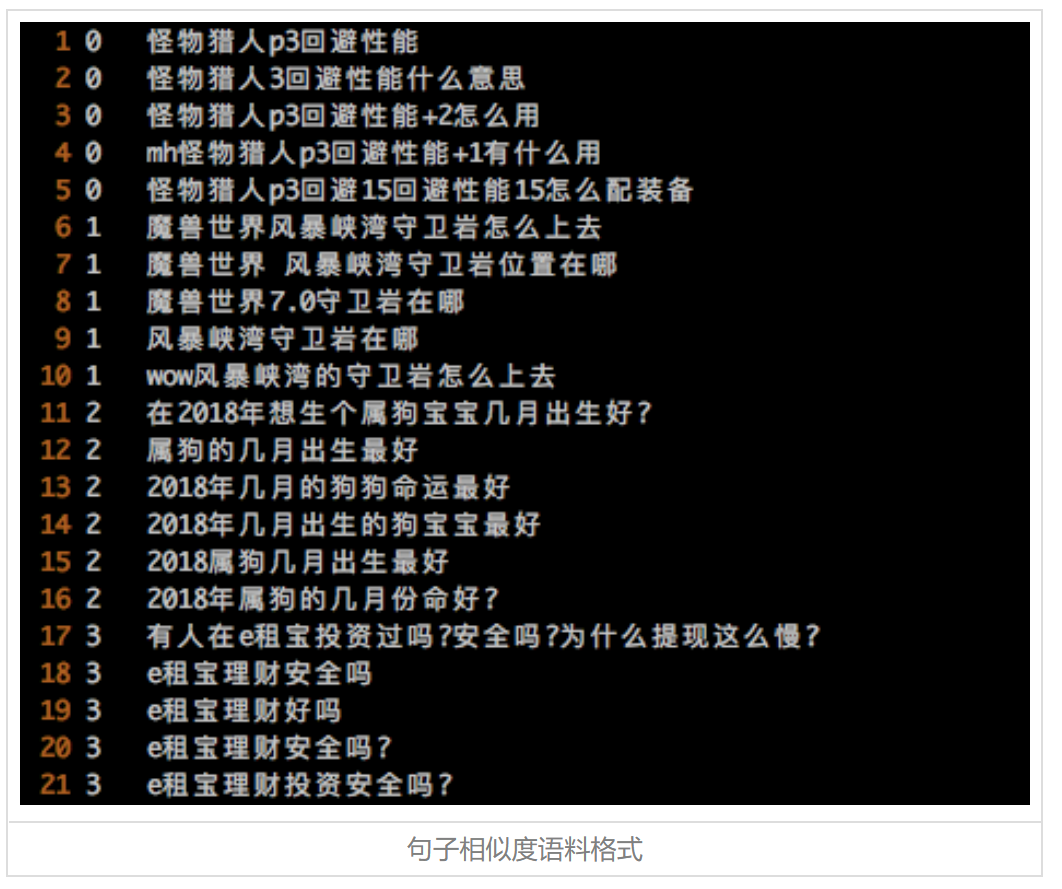
其中前面的id表示句子组别，用\t隔开，同一组的句子可以认为都是同一句，不同组的句子则是非同义句。

In [101]:
import os, sys
import json
from pathlib import Path

In [102]:
def load_data(file):       
    D = []
    with open(file, 'r', encoding='utf-8') as f:
        for l in f:
            text1, text2, label = l.strip().split('\t')
            D.append((text1, text2, int(label)))
    return D

In [103]:
def gen_synsets(dataset):
    synsent_set_dicts = {}
    sent2set_idx = {}    
    deleted_sets = set([])
    for is_end, (text1, text2, label) in enumerate(dataset):
            if label == 1:
                retrieve_synsets(synsent_set_dicts,sent2set_idx,deleted_sets,text1,text2) 
    for deleted_setid in deleted_sets:
        synsent_set_dicts.pop(deleted_setid)        
    
    return synsent_set_dicts                

def retrieve_synsets(synsent_set_dicts,syn_idx,deleted_sets,text1,text2):    
    #set_id = [setid  for setid,syn_set in syn_dicts.items() if (text1 in syn_set or text2 in syn_set)]
    text1_set_id = text2_set_id = -1
    if text1 in syn_idx:
        set_id = text1_set_id = syn_idx[text1]
    if text2 in syn_idx:
        set_id = text2_set_id = syn_idx[text2] 
    # 如果两者都已经有同义句集合，那么两者应该属于同一个集合，
    # 则创建新集合，新集合是两个集合的合并
    # 并将原有两个集合的文本到集合映射到新的集合上
    if (text1_set_id != -1 and text2_set_id != -1):
        if text1_set_id != text2_set_id:
            synsent_set_dicts[len(synsent_set_dicts)] = synsent_set_dicts[text1_set_id].union(synsent_set_dicts[text2_set_id])
            for text in synsent_set_dicts[text1_set_id]:
                syn_idx[text] = len(synsent_set_dicts) - 1
            for text in synsent_set_dicts[text2_set_id]:
                syn_idx[text] = len(synsent_set_dicts) - 1
            deleted_sets.add(text1_set_id)
            deleted_sets.add(text2_set_id)
    # 如果两者有一个属于同义句集合，那么另一个应该也属于这个集合
    elif (text1_set_id != -1 or text2_set_id != -1):  
        synsent_set_dicts[set_id].add(text2)
        synsent_set_dicts[set_id].add(text1)
        syn_idx[text1]=syn_idx[text2] = set_id
    else:
        new_set = set([text1,text2])
        synsent_set_dicts[len(synsent_set_dicts)] = new_set   
        syn_idx[text1] = syn_idx[text2] = len(synsent_set_dicts)-1

In [104]:
def gen_datafile(syn_dicts, filename):
    with open(filename, 'w', encoding='utf-8') as f:  
        group_id = 0
        for idx,sent_set in syn_dicts.items():
            for sent in sent_set:
                f.write("%d\t%s\n" %(group_id,sent))
            group_id = group_id + 1
    

In [105]:
from pathlib import Path

# dataset_path = '../datasets/sentence-similarity-zoo-master/data'
dataset_path = r'D:\资料\数据\相似句子'

LCQMC = [
    'LCQMC/processed/train.tsv',
    'LCQMC/processed/dev.tsv',
    'LCQMC/processed/test.tsv',
    ]

CCKS = [
    'CCKS/processed/train.tsv',
    'CCKS/processed/dev.tsv',
    'CCKS/processed/test.tsv',
    ]

ATEC = [
    'ATEC/processed/train.tsv',
    'ATEC/processed/dev.tsv',
    'ATEC/processed/test.tsv',
    ]

CORPUS = [
    (LCQMC,'LCQMC'),
    (CCKS, 'CCKS'),
    (ATEC, 'ATEC')    
    ]

In [106]:
# 加载数据集
dataset_dir = Path(dataset_path)
for data in CORPUS:    
    dataset = data[0]
    train_file = dataset_dir / dataset[0]
    dev_file = dataset_dir / dataset[1]
    test_file = dataset_dir / dataset[2]   
    
    train_data = load_data(train_file)
    valid_data = load_data(dev_file)
    test_data = load_data(dev_file)
    
    train_syn_dicts = gen_synsets(train_data)
    val_syn_dicts = gen_synsets(valid_data)
    test_syn_dicts = gen_synsets(test_data)
    
    dataset_name = data[1]
    gen_datafile(train_syn_dicts,dataset_name+"_train_syn_sent.txt")    
    gen_datafile(val_syn_dicts,dataset_name+"_val_syn_sent.txt")
    gen_datafile(test_syn_dicts,dataset_name+"_test_syn_sent.txt")

ValueError: invalid literal for int() with base 10: 'label'

ValueError: invalid literal for int() with base 10: 'label'

ValueError: invalid literal for int() with base 10: 'label'

ValueError: invalid literal for int() with base 10: 'label'

ValueError: invalid literal for int() with base 10: 'label'

ValueError: invalid literal for int() with base 10: 'label'

进行数据实验，首先使用GRU+am-softmax模型:

In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import json

In [ ]:
train_data = pd.read_csv('train_syn_sent.txt', encoding='utf-8', header=None, delimiter='\t')

In [ ]:
val_data = pd.read_csv('val_syn_sent.txt', encoding='utf-8', header=None, delimiter='\t')

In [ ]:
def strQ2B(ustring): # 全角转半角
    rstring = ''
    for uchar in ustring:
        inside_code=ord(uchar)
        if inside_code == 12288: # 全角空格直接转换
            inside_code = 32
        elif (inside_code >= 65281 and inside_code <= 65374): # 全角字符（除空格）根据关系转化
            inside_code -= 65248
        rstring += chr(inside_code)
    return rstring

In [ ]:
train_data[1] = train_data[1].apply(strQ2B)
train_data[1] = train_data[1].str.lower()

val_data[1] = val_data[1].apply(strQ2B)
val_data[1] = val_data[1].str.lower()

In [ ]:
chars = {}
for s in tqdm(iter(train_data[1])):
    for c in s:
        if c not in chars:
            chars[c] = 0
        chars[c] += 1

In [ ]:
min_count = 5

# 0: padding标记
# 1: unk标记
chars = {i:j for i,j in chars.items() if j >= min_count}
id2char = {i+2:j for i,j in enumerate(chars)}
char2id = {j:i for i,j in id2char.items()}

In [ ]:
maxlen = 32
def string2id(s):
    _ = [char2id.get(i, 1) for i in s[:maxlen]]
    _ = _ + [0] * (maxlen - len(_))
    return _

In [ ]:
train_data[2] = train_data[1].apply(string2id)
train_data = train_data.sample(frac=1)

val_data[2] = val_data[1].apply(string2id)


x_train = np.array(list(train_data[2]))
y_train = np.array(list(train_data[0])).reshape((-1,1))



In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.constraints import unit_norm
from tensorflow.keras import backend as K 

In [ ]:
word_size = 128

# 正式模型，基于GRU的分类器
x_in = Input(shape=(maxlen,))
x_embedded = Embedding(len(chars)+2,
                       word_size)(x_in)
x = GRU(word_size)(x_embedded)
x = Lambda(lambda x: K.l2_normalize(x, 1))(x)

pred = Dense(max(train_data[0])+1,
             use_bias=False,
             kernel_constraint=unit_norm())(x)

encoder = Model(x_in, x) # 最终的目的是要得到一个编码器
model = Model(x_in, pred) # 用分类问题做训练

In [ ]:
encoder.summary()

In [ ]:
from margin_softmax import *

In [ ]:
model.compile(loss=sparse_amsoftmax_loss,
              optimizer='adam',
              metrics=['sparse_categorical_accuracy'])

In [ ]:
# 为验证集的排序准备
# 实际上用numpy写也没有问题，但是用Keras写能借助GPU加速
x_in = Input(shape=(word_size,))
x = Dense(len(val_data), use_bias=False)(x_in) # 计算相似度
x = Lambda(lambda x: tf.nn.top_k(x, 11)[1])(x) # 取出topk的下标
model_sort = Model(x_in, x)

In [ ]:
# id与组别之间的映射
id2g = dict(zip(val_data.index-val_data.index[0], val_data[0]))

In [ ]:
model_sort.summary()

In [ ]:
from tensorflow.keras.callbacks import Callback

In [ ]:
def evaluate(): # 评测函数
    print('validing...') 
    valid_vec = encoder.predict(np.array(list(val_data[2])),
                                verbose=True,
                                batch_size=1000) # encoder计算句向量
    model_sort.set_weights([valid_vec.T]) # 载入句向量为权重
    sorted_result = model_sort.predict(valid_vec,
                                       verbose=True,
                                       batch_size=1000) # 计算topk
    new_result = np.vectorize(lambda s: id2g[s])(sorted_result)
    _ = new_result[:, 0] != new_result[:, 0] # 生成一个全为False的向量
    for i in range(10): # 注意按照相似度排序的话，第一个就是输入句子（全匹配）
        _ = _ + (new_result[:, 0] == new_result[:, i+1])
        if i+1 == 1:
            top1_acc = 1. * _.sum() / len(_)
        elif i+1 == 5:
            top5_acc = 1. * _.sum() / len(_)
        elif i+1 == 10:
            top10_acc = 1. * _.sum() / len(_)

    return top1_acc, top5_acc, top10_acc


# 定义Callback器，计算验证集的acc，并保存最优模型
class Evaluate(Callback):
    def __init__(self):
        self.accs = {'top1': [], 'top5': [], 'top10': []}
        self.highest = 0.
    def on_epoch_end(self, epoch, logs=None):
        top1_acc, top5_acc, top10_acc = evaluate()
        self.accs['top1'].append(top1_acc)
        self.accs['top5'].append(top5_acc)
        self.accs['top10'].append(top10_acc)
        if top1_acc >= self.highest: # 保存最优模型权重
            self.highest = top1_acc
            model.save_weights('sent_sim_amsoftmax.model')
        json.dump({'accs': self.accs, 'highest_top1': self.highest},
                  open('valid_amsoftmax.log', 'w'), indent=4)
        print('top1_acc: %s, top5_acc: %s, top10_acc: %s' % (top1_acc, top5_acc, top10_acc))

In [ ]:
batch_size = 100
epochs = 30 
evaluator = Evaluate()

history = model.fit(x_train,
                    y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    callbacks=[evaluator])

top1_acc: 0.7500660501981506, top5_acc: 0.8854689564068692, top10_acc: 0.9157199471598415

In [ ]:
model.save('lcmq_sem_sim_gru.h5')

In [ ]:
val_vec = encoder.predict(np.array(list(val_data[2])),
                            verbose=True,
                            batch_size=1000) # encoder计算句向量

def most_similar(s):
    v = encoder.predict(np.array([string2id(s)]))[0]
    sims = np.dot(val_vec, v)
    for i in sims.argsort()[-10:][::-1]:
        print(val_data.iloc[i][1],sims[i])




In [ ]:
most_similar(u'初婚未育情况证明怎么开？')

In [ ]:
most_similar(u'哪个购物网站是货到付款的')

In [ ]:
most_similar(u'显卡驱动安装不了')

下面用BERT对句子进行编码，分别使用CLS向量和平均向量进行编码:

In [ ]:
from bert4keras.tokenizers import Tokenizer
from bert4keras.models import build_transformer_model

In [ ]:
import os, sys
os.environ["TF_KERAS"]='1'

In [ ]:
config_path = "..\\pretrained_model\\chinese_L-12_H-768_A-12\\bert_config.json"
checkpoint_path ="..\\pretrained_model\\chinese_L-12_H-768_A-12\\bert_model.ckpt"
dict_path = "..\\pretrained_model\\chinese_L-12_H-768_A-12\\vocab.txt"

In [ ]:
# 建立分词器
bert_tokenizer = Tokenizer(dict_path, do_lower_case=True)

In [ ]:
# 加载预训练模型
bert = build_transformer_model(
    config_path=config_path,
    checkpoint_path=checkpoint_path,
)

In [ ]:
from tensorflow.keras.layers import Lambda
from bert4keras.backend import keras, K

In [ ]:
cls_output = Lambda(lambda x: x[:, 0])(bert.output)
cls_output = Lambda(lambda x: K.l2_normalize(x, 1))(cls_output)
bert_cls_encoder = keras.models.Model(bert.inputs, cls_output)
bert_cls_encoder.summary()

In [ ]:
from tensorflow.keras.layers import GlobalAveragePooling1D

In [ ]:
mean_output = GlobalAveragePooling1D()(bert.output)
mean_output = Lambda(lambda x: K.l2_normalize(x, 1))(mean_output)
bert_mean_encoder = keras.models.Model(bert.inputs, mean_output)
bert_mean_encoder.summary()

SIM_BERT模型编码器

In [ ]:
config_path = "..\\pretrained_model\\chinese_simbert_L-12_H-768_A-12\\bert_config.json"
checkpoint_path ="..\\pretrained_model\\chinese_simbert_L-12_H-768_A-12\\bert_model.ckpt"
dict_path = "..\\pretrained_model\\chinese_simbert_L-12_H-768_A-12\\vocab.txt"

In [ ]:
# 建立分词器
sim_bert_tokenizer = Tokenizer(dict_path, do_lower_case=True)  # 建立分词器

# 建立加载模型
sim_bert = build_transformer_model(
    config_path,
    checkpoint_path,
    with_pool='linear',
    application='unilm',
    return_keras_model=False,
)

In [ ]:
sim_cls_output = sim_bert.output[0]
sim_cls_output = Lambda(lambda x: K.l2_normalize(x, 1))(sim_cls_output)
sim_cls_encoder = keras.models.Model(sim_bert.inputs, sim_cls_output)
sim_cls_encoder.summary()

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *

In [ ]:
word_size = 768

In [ ]:
def build_sort_model(data_len):
    # 为验证集的排序准备
    # 实际上用numpy写也没有问题，但是用Keras写能借助GPU加速
    x_in = Input(shape=(word_size,))
    x = Dense(data_len, use_bias=False)(x_in) # 计算相似度
    x = Lambda(lambda x: tf.nn.top_k(x, 11)[1])(x) # 取出topk的下标
    model_sort = Model(x_in, x)
    return model_sort

In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import json

In [ ]:
def evaluate_encoder(tokenizer,encoder,val_data): # 评测函数
    print('validing...')     
    # 计算句向量
    valid_vec = np.zeros((len(val_data),word_size))   
    idx = 0    
    for sent in iter(val_data[1]):
        token_ids, segment_ids = tokenizer.encode(sent)
        valid_vec[idx] = encoder.predict([np.array([token_ids]), np.array([segment_ids])])
        idx += 1

    model_sort = build_sort_model(len(val_data))
    model_sort.set_weights([valid_vec.T]) # 载入句向量为权重
    sorted_result = model_sort.predict(valid_vec,
                                       verbose=True,
                                       batch_size=1000) # 计算topk
    
    # id与组别之间的映射
    id2g = dict(zip(val_data.index-val_data.index[0], val_data[0]))
    
    new_result = np.vectorize(lambda s: id2g[s])(sorted_result)
    _ = new_result[:, 0] != new_result[:, 0] # 生成一个全为False的向量
    for i in range(10): # 注意按照相似度排序的话，第一个就是输入句子（全匹配）
        _ = _ + (new_result[:, 0] == new_result[:, i+1])
        if i+1 == 1:
            top1_acc = 1. * _.sum() / len(_)
        elif i+1 == 5:
            top5_acc = 1. * _.sum() / len(_)
        elif i+1 == 10:
            top10_acc = 1. * _.sum() / len(_)

    return top1_acc, top5_acc, top10_acc

In [ ]:
from pathlib import Path

dataset_path = '../datasets/sentence-similarity-zoo-master/data'

#LCQMC = [
#    'LCQMC/processed/train.tsv',
#    'LCQMC/processed/dev.tsv',
#    'LCQMC/processed/test.tsv',
#    ]


#CCKS = [
#    'CCKS/processed/train.tsv',
#    'CCKS/processed/dev.tsv',
#    'CCKS/processed/test.tsv',
#    ]

ATEC = [
    'ATEC/processed/train.tsv',
    'ATEC/processed/dev.tsv',
    'ATEC/processed/test.tsv',
    ]

CORPUS = [
#    (LCQMC,'LCQMC'),
#    (CCKS, 'CCKS'),
    (ATEC, 'ATEC')    
    ]

In [ ]:
def strQ2B(ustring): # 全角转半角
    rstring = ''
    for uchar in ustring:
        inside_code=ord(uchar)
        if inside_code == 12288: # 全角空格直接转换
            inside_code = 32
        elif (inside_code >= 65281 and inside_code <= 65374): # 全角字符（除空格）根据关系转化
            inside_code -= 65248
        rstring += chr(inside_code)
    return rstring

In [ ]:
for data in CORPUS:    
    dataset_name = data[1]
    val_data = pd.read_csv(dataset_name+"_val_syn_sent.txt", encoding='utf-8', header=None, delimiter='\t')
    val_data[1] = val_data[1].apply(strQ2B)
    val_data[1] = val_data[1].str.lower()
    
    top1_acc, top5_acc, top10_acc = evaluate_encoder(bert_tokenizer,bert_cls_encoder,val_data)
    print(dataset_name + ' by bert_cls_encoder: top1_acc: %s, top5_acc: %s, top10_acc: %s' % (top1_acc, top5_acc, top10_acc))
    
    top1_acc, top5_acc, top10_acc = evaluate_encoder(bert_tokenizer,bert_mean_encoder,val_data)
    print(dataset_name + ' by bert_mean_encoder: top1_acc: %s, top5_acc: %s, top10_acc: %s' % (top1_acc, top5_acc, top10_acc))
        
    top1_acc, top5_acc, top10_acc = evaluate_encoder(sim_bert_tokenizer,sim_cls_encoder,val_data)
    print(dataset_name + ' by sim_bert_cls_encoder: top1_acc: %s, top5_acc: %s, top10_acc: %s' % (top1_acc, top5_acc, top10_acc))
    

FileNotFoundError: [Errno 2] File b'ATEC_val_syn_sent.txt' does not exist: b'ATEC_val_syn_sent.txt'

LCQMC:
* Mean Encoder:top1_acc: 0.8443857331571994, top5_acc: 0.9675033025099076, top10_acc: 0.9873183619550858
* CLS Encoder: top1_acc: 0.6443857331571995, top5_acc: 0.8125495376486129, top10_acc: 0.8631439894319684
* SIM_BERT_CLS_Encoder: top1_acc: 0.8792602377807134, top5_acc: 0.988110964332893, top10_acc: 0.9964332892998679
* GRU_Encoder: top1_acc: 0.7500660501981506, top5_acc: 0.8854689564068692, top10_acc: 0.9157199471598415
* LCQMC by AVG_embedding: top1_acc: 0.702774108322325, top5_acc: 0.8729194187582563, top10_acc: 0.9126816380449141
* LCQMC by FREQ_embedding: top1_acc: 0.7015852047556143, top5_acc: 0.8785997357992074, top10_acc: 0.9190224570673712
* LCQMC by SIF_embedding: top1_acc: 0.7114927344782034, top5_acc: 0.8939233817701453, top10_acc: 0.9315719947159842

CCKS:
* CCKS by bert_mean_encoder: top1_acc: 0.17268894911171334, top5_acc: 0.3788015657934357, top10_acc: 0.4670280036133695  
* CCKS by bert_cls_encoder: top1_acc: 0.14001806684733514, top5_acc: 0.30186690755796447, top10_acc: 0.3771454381210479
* CCKS by sim_bert_cls_encoder: top1_acc: 0.1919602529358627, top5_acc: 0.4340560072267389, top10_acc: 0.5412526347485697
* CCKS by AVG_embedding: top1_acc: 0.1451370069256248, top5_acc: 0.322192110809997, top10_acc: 0.39129780186690755
* CCKS by FREQ_embedding: top1_acc: 0.14348087925323696, top5_acc: 0.31752484191508584, top10_acc: 0.3953628425173141
* CCKS by SIF_embedding: top1_acc: 0.1473953628425173, top5_acc: 0.3327311050888287, top10_acc: 0.4170430593194821

ATEC:
* ATEC by bert_cls_encoder: top1_acc: 0.07351865398683248, top5_acc: 0.17044623262618874, top10_acc: 0.2264081931236284 
* ATEC by bert_mean_encoder: top1_acc: 0.12966349670811997, top5_acc: 0.29645208485735186, top10_acc: 0.39392831016825164
* ATEC by sim_bert_cls_encoder: top1_acc: 0.20226773957571323, top5_acc: 0.45921726408193125, top10_acc: 0.6036942209217264
* ATEC by AVG_embedding: top1_acc: 0.10113386978785661, top5_acc: 0.2260424286759327, top10_acc: 0.29846378931967815
* ATEC by FREQ_embedding: top1_acc: 0.1005852231163131, top5_acc: 0.22970007315288954, top10_acc: 0.302121433796635   
* ATEC by SIF_embedding: top1_acc: 0.10479151426481347, top5_acc: 0.24945135332845647, top10_acc: 0.3301024140453548

In [ ]:
import os

In [ ]:
from bert4keras.tokenizers import Tokenizer
from bert4keras.models import build_transformer_model

In [ ]:
import os, sys
os.environ["TF_KERAS"]='1'

In [ ]:
config_path = "..\\pretrained_model\\chinese_L-12_H-768_A-12\\bert_config.json"
checkpoint_path ="..\\pretrained_model\\chinese_L-12_H-768_A-12\\bert_model.ckpt"
dict_path = "..\\pretrained_model\\chinese_L-12_H-768_A-12\\vocab.txt"

In [ ]:
# 建立分词器
bert_tokenizer = Tokenizer(dict_path, do_lower_case=True)

In [ ]:
from tensorflow.keras.layers import Dropout, Dense, subtract, multiply, maximum, Concatenate
from tensorflow.keras import Model, Input
import tensorflow as tf

In [ ]:
from tensorflow.keras.layers import Lambda
from bert4keras.backend import keras, set_gelu, K

In [ ]:
set_gelu('tanh')  # 切换gelu版本

In [ ]:
# 加载预训练模型
bert = build_transformer_model(
    config_path=config_path,
    checkpoint_path=checkpoint_path,
    with_pool=True,
    return_keras_model=False,
)

norm_output = Lambda(lambda x: K.l2_normalize(x, 1))(bert.output)
sentence_encoder = keras.models.Model(bert.inputs, norm_output)

NameError: name 'build_transformer_model' is not defined

In [ ]:
sentence_encoder.input

In [ ]:
q1_x_in = Input(shape = (None,), name='Input-Token-q1')
q1_s_in = Input(shape = (None,), name='Input-Segment-q1')

q2_x_in = Input(shape = (None,), name='Input-Token-q2')
q2_s_in = Input(shape = (None,), name='Input-Segment-q2')

u_input = sentence_encoder([q1_x_in,q1_s_in])
v_input = sentence_encoder([q2_x_in,q2_s_in])
    
# |q1-q2| 两特征之差的绝对值
sub = tf.abs(subtract([u_input, v_input]))
# q1*q2 两特征按元素相乘
mul = multiply([u_input, v_input])
# max(q1,q2)^2 两特征取最大元素的平方
max_square = multiply([maximum([u_input, v_input]), maximum([u_input, v_input])])

merge_layers = Concatenate()([u_input, v_input, sub, mul, max_square])
merge_layers = Dropout(rate=0.1)(merge_layers)

similarity = Dense(
    units=2, activation='softmax', kernel_initializer=bert.initializer
)(merge_layers)


In [ ]:
model = Model([q1_x_in,q1_s_in,q2_x_in,q2_s_in], similarity)
model.summary()

In [ ]:
from bert4keras.optimizers import Adam

In [ ]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(2e-5),  # 用足够小的学习率
    # optimizer=PiecewiseLinearLearningRate(Adam(5e-5), {10000: 1, 30000: 0.1}),
    metrics=['accuracy'],
)

In [ ]:
from bert4keras.snippets import sequence_padding, DataGenerator

In [ ]:
maxlen = 128
class data_generator(DataGenerator):
    """数据生成器
    """
    def __iter__(self, random=False):
        q1_batch_token_ids, q1_batch_segment_ids, q2_batch_token_ids, q2_batch_segment_ids,batch_labels = [], [],[], [],[]
        for is_end, (text1, text2, label) in self.sample(random):
            q1_token_ids, q1_segment_ids = bert_tokenizer.encode(text1, maxlen=maxlen)
            q2_token_ids, q2_segment_ids = bert_tokenizer.encode(text2, maxlen=maxlen)
            q1_batch_token_ids.append(q1_token_ids)
            q1_batch_segment_ids.append(q1_segment_ids)            
            q2_batch_token_ids.append(q2_token_ids)
            q2_batch_segment_ids.append(q2_segment_ids)            
            batch_labels.append([label])
            
            if len(batch_labels) == self.batch_size or is_end:
                q1_batch_token_ids = sequence_padding(q1_batch_token_ids)
                q1_batch_segment_ids = sequence_padding(q1_batch_segment_ids)
                q2_batch_token_ids = sequence_padding(q2_batch_token_ids)
                q2_batch_segment_ids = sequence_padding(q2_batch_segment_ids)                
                batch_labels = sequence_padding(batch_labels)
                
                yield [q1_batch_token_ids, q1_batch_segment_ids,q2_batch_token_ids, q2_batch_segment_ids], batch_labels
                q1_batch_token_ids, q1_batch_segment_ids, q2_batch_token_ids, q2_batch_segment_ids,batch_labels = [], [],[], [],[]

In [ ]:
from pathlib import Path

In [ ]:
def load_data(path, filename):   
    file = path / filename
    D = []
    with open(file, 'r', encoding='utf-8') as f:
        for l in f:
            text1, text2, label = l.strip().split('\t')
            D.append((text1, text2, int(label)))
    return D

In [107]:
batch_size = 32
path = Path('../datasets/sentence-similarity-zoo-master/data/CCKS/processed/')

# 加载数据集
train_data = load_data(path,'train.tsv')
valid_data = load_data(path,'dev.tsv')

# 转换数据集
train_generator = data_generator(train_data, batch_size)
valid_generator = data_generator(valid_data, batch_size)

TypeError: load_data() takes 1 positional argument but 2 were given

In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import json

In [ ]:
word_size = 768

def build_sort_model(data_len):
    # 为验证集的排序准备
    # 实际上用numpy写也没有问题，但是用Keras写能借助GPU加速
    x_in = Input(shape=(word_size,))
    x = Dense(data_len, use_bias=False)(x_in) # 计算相似度
    x = Lambda(lambda x: tf.nn.top_k(x, 11)[1])(x) # 取出topk的下标
    model_sort = Model(x_in, x)
    return model_sort

def evaluate_encoder(tokenizer,encoder,val_data): # 评测函数
    print('validing...')     
    # 计算句向量
    valid_vec = np.zeros((len(val_data),word_size))   
    idx = 0    
    for sent in iter(val_data[1]):
        token_ids, segment_ids = tokenizer.encode(sent)
        valid_vec[idx] = encoder.predict([np.array([token_ids]), np.array([segment_ids])])
        idx += 1

    model_sort = build_sort_model(len(val_data))
    model_sort.set_weights([valid_vec.T]) # 载入句向量为权重
    sorted_result = model_sort.predict(valid_vec,
                                       verbose=True,
                                       batch_size=1000) # 计算topk
    
    # id与组别之间的映射
    id2g = dict(zip(val_data.index-val_data.index[0], val_data[0]))
    
    new_result = np.vectorize(lambda s: id2g[s])(sorted_result)
    _ = new_result[:, 0] != new_result[:, 0] # 生成一个全为False的向量
    for i in range(10): # 注意按照相似度排序的话，第一个就是输入句子（全匹配）
        _ = _ + (new_result[:, 0] == new_result[:, i+1])
        if i+1 == 1:
            top1_acc = 1. * _.sum() / len(_)
        elif i+1 == 5:
            top5_acc = 1. * _.sum() / len(_)
        elif i+1 == 10:
            top10_acc = 1. * _.sum() / len(_)

    return top1_acc, top5_acc, top10_acc

from pathlib import Path

dataset_path = '../datasets/sentence-similarity-zoo-master/data'

CCKS = [
    'CCKS/processed/train.tsv',
    'CCKS/processed/dev.tsv',
    'CCKS/processed/test.tsv',
    ]

CORPUS = [
    (CCKS, 'CCKS'),
    ]

def strQ2B(ustring): # 全角转半角
    rstring = ''
    for uchar in ustring:
        inside_code=ord(uchar)
        if inside_code == 12288: # 全角空格直接转换
            inside_code = 32
        elif (inside_code >= 65281 and inside_code <= 65374): # 全角字符（除空格）根据关系转化
            inside_code -= 65248
        rstring += chr(inside_code)
    return rstring
    
    
class Evaluator(keras.callbacks.Callback):
    """评估与保存
    """
    def __init__(self):
        self.best_val_acc = 0.

    def on_epoch_end(self, epoch, logs=None):
        val_acc = evaluate(valid_generator)
        if val_acc > self.best_val_acc:
            self.best_val_acc = val_acc
            model.save_weights('siamese_bert_sentpair_best_model.weights')
        
        print(
            u'val_acc: %.5f, best_val_acc: %.5f\n' %
            (val_acc, self.best_val_acc)
        )
        
        for data in CORPUS:    
            dataset_name = data[1]
            val_data = pd.read_csv(dataset_name+"_val_syn_sent.txt", encoding='utf-8', header=None, delimiter='\t')
            val_data[1] = val_data[1].apply(strQ2B)
            val_data[1] = val_data[1].str.lower()
    
        top1_acc, top5_acc, top10_acc = evaluate_encoder(bert_tokenizer,sentence_encoder,val_data)
        print(dataset_name + ' by bert_cls_encoder: top1_acc: %s, top5_acc: %s, top10_acc: %s\n' % (top1_acc, top5_acc, top10_acc))
        

In [ ]:
evaluator = Evaluator()

model.fit(
    train_generator.forfit(),
    steps_per_epoch=len(train_generator),
    epochs=5,
    callbacks=[evaluator]
)

NameError: name 'model' is not defined

训练SIMBERT

In [ ]:
import json
import pandas as pd
from pathlib import Path
import numpy as np

In [ ]:
def strQ2B(ustring): # 全角转半角
    rstring = ''
    for uchar in ustring:
        inside_code=ord(uchar)
        if inside_code == 12288: # 全角空格直接转换
            inside_code = 32
        elif (inside_code >= 65281 and inside_code <= 65374): # 全角字符（除空格）根据关系转化
            inside_code -= 65248
        rstring += chr(inside_code)
    return rstring

In [ ]:
train_data = pd.read_csv(Path("CCKS_train_syn_sent.txt"), encoding='utf-8', header=None, delimiter='\t')
train_data[1] = train_data[1].apply(strQ2B)
train_data[1] = train_data[1].str.lower()

In [ ]:
train_data.head(10)

In [ ]:
list(train_data.loc[train_data[0] == 1][1][1:])

In [ ]:
train_data.loc[train_data[0] == 1][1]

In [ ]:
D = {}
with open('CCKS_sim_bert_train.json','w', encoding='utf-8') as f:
    for group in set(train_data[0]):
        sent_group = list(train_data.loc[train_data[0] == group][1])
        D['text'] = sent_group[0]
        D['synonyms'] = sent_group[1:]
        f.write(json.dumps(D,ensure_ascii=False)+'\n')        
        D = {}

In [ ]:
import os

In [ ]:
os.environ["TF_KERAS"]='1'

In [ ]:
from collections import Counter
from bert4keras.backend import keras, K
from bert4keras.layers import Loss
from bert4keras.models import build_transformer_model
from bert4keras.tokenizers import Tokenizer, load_vocab
from bert4keras.optimizers import Adam, extend_with_weight_decay
from bert4keras.snippets import DataGenerator
from bert4keras.snippets import sequence_padding
from bert4keras.snippets import text_segmentate
from bert4keras.snippets import AutoRegressiveDecoder
from bert4keras.snippets import uniout

In [ ]:
# 基本信息
maxlen = 32
batch_size = 32
steps_per_epoch = 1000
epochs = 10000
corpus_path = 'CCKS_sim_bert_train.json'

In [ ]:
config_path = "..\\pretrained_model\\chinese_L-12_H-768_A-12\\bert_config.json"
checkpoint_path ="..\\pretrained_model\\chinese_L-12_H-768_A-12\\bert_model.ckpt"
dict_path = "..\\pretrained_model\\chinese_L-12_H-768_A-12\\vocab.txt"

In [ ]:
# 加载并精简词表，建立分词器
token_dict, keep_tokens = load_vocab(
    dict_path=dict_path,
    simplified=True,
    startswith=['[PAD]', '[UNK]', '[CLS]', '[SEP]'],
)

FileNotFoundError: [Errno 2] No such file or directory: '..\\pretrained_model\\chinese_L-12_H-768_A-12\\vocab.txt'

FileNotFoundError: [Errno 2] No such file or directory: '..\\pretrained_model\\chinese_L-12_H-768_A-12\\vocab.txt'

In [ ]:
tokenizer = Tokenizer(token_dict, do_lower_case=True)

In [ ]:
def read_corpus():
    """读取语料，每行一个json
    """
    while True:
        with open(corpus_path) as f:
            for l in f:
                yield json.loads(l)


In [ ]:
def truncate(text):
    """截断句子
    """
    seps, strips = u'\n。！？!?；;，, ', u'；;，, '
    return text_segmentate(text, maxlen - 2, seps, strips)[0]

In [ ]:
class data_generator(DataGenerator):
    """数据生成器
    """
    def __init__(self, *args, **kwargs):
        super(data_generator, self).__init__(*args, **kwargs)
        self.some_samples = []

    def __iter__(self, random=False):
        batch_token_ids, batch_segment_ids = [], []
        for is_end, d in self.sample(random):
            text, synonyms = d['text'], d['synonyms']
            synonyms = [text] + synonyms
            np.random.shuffle(synonyms)
            text, synonym = synonyms[:2]
            text, synonym = truncate(text), truncate(synonym)
            self.some_samples.append(text)
            if len(self.some_samples) > 1000:
                self.some_samples.pop(0)
            token_ids, segment_ids = tokenizer.encode(
                text, synonym, max_length=maxlen * 2
            )
            batch_token_ids.append(token_ids)
            batch_segment_ids.append(segment_ids)
            token_ids, segment_ids = tokenizer.encode(
                synonym, text, max_length=maxlen * 2
            )
            batch_token_ids.append(token_ids)
            batch_segment_ids.append(segment_ids)
            if len(batch_token_ids) == self.batch_size or is_end:
                batch_token_ids = sequence_padding(batch_token_ids)
                batch_segment_ids = sequence_padding(batch_segment_ids)
                yield [batch_token_ids, batch_segment_ids], None
                batch_token_ids, batch_segment_ids = [], []


In [ ]:
class TotalLoss(Loss):
    """loss分两部分，一是seq2seq的交叉熵，二是相似度的交叉熵。
    """
    def compute_loss(self, inputs, mask=None):
        loss1 = self.compute_loss_of_seq2seq(inputs, mask)
        loss2 = self.compute_loss_of_similarity(inputs, mask)
        self.add_metric(loss1, name='seq2seq_loss')
        self.add_metric(loss2, name='similarity_loss')
        return loss1 + loss2

    def compute_loss_of_seq2seq(self, inputs, mask=None):
        y_true, y_mask, _, y_pred = inputs
        y_true = y_true[:, 1:]  # 目标token_ids
        y_mask = y_mask[:, 1:]  # segment_ids，刚好指示了要预测的部分
        y_pred = y_pred[:, :-1]  # 预测序列，错开一位
        loss = K.sparse_categorical_crossentropy(y_true, y_pred)
        loss = K.sum(loss * y_mask) / K.sum(y_mask)
        return loss

    def compute_loss_of_similarity(self, inputs, mask=None):
        _, _, y_pred, _ = inputs
        y_true = self.get_labels_of_similarity(y_pred)  # 构建标签
        y_pred = K.l2_normalize(y_pred, axis=1)  # 句向量归一化
        similarities = K.dot(y_pred, K.transpose(y_pred))  # 相似度矩阵
        similarities = similarities - K.eye(K.shape(y_pred)[0]) * 1e12  # 排除对角线
        similarities = similarities * 30  # scale
        loss = K.categorical_crossentropy(
            y_true, similarities, from_logits=True
        )
        return loss

    def get_labels_of_similarity(self, y_pred):
        idxs = K.arange(0, K.shape(y_pred)[0])
        idxs_1 = idxs[None, :]
        idxs_2 = (idxs + 1 - idxs % 2 * 2)[:, None]
        labels = K.equal(idxs_1, idxs_2)
        labels = K.cast(labels, K.floatx())
        return labels

In [ ]:
# 建立加载模型
bert = build_transformer_model(
    config_path,
    checkpoint_path,
    with_pool='linear',
    application='unilm',
    keep_tokens=keep_tokens,  # 只保留keep_tokens中的字，精简原字表
    return_keras_model=False,
)

In [ ]:
class SynonymsGenerator(AutoRegressiveDecoder):
    """seq2seq解码器
    """
    @AutoRegressiveDecoder.set_rtype('probas')
    def predict(self, inputs, output_ids, step):
        token_ids, segment_ids = inputs
        token_ids = np.concatenate([token_ids, output_ids], 1)
        segment_ids = np.concatenate([segment_ids, np.ones_like(output_ids)], 1)
        return seq2seq.predict([token_ids, segment_ids])[:, -1]

    def generate(self, text, n=1, topk=5):
        token_ids, segment_ids = tokenizer.encode(text, max_length=maxlen)
        output_ids = self.random_sample([token_ids, segment_ids], n,
                                        topk)  # 基于随机采样
        return [tokenizer.decode(ids) for ids in output_ids]


synonyms_generator = SynonymsGenerator(
    start_id=None, end_id=tokenizer._token_end_id, maxlen=maxlen
)

In [ ]:
def gen_synonyms(text, n=100, k=20):
    """"含义： 产生sent的n个相似句，然后返回最相似的k个。
    做法：用seq2seq生成，并用encoder算相似度并排序。
    效果：
        >>> gen_synonyms(u'微信和支付宝哪个好？')
        [
            u'微信和支付宝，哪个好?',
            u'微信和支付宝哪个好',
            u'支付宝和微信哪个好',
            u'支付宝和微信哪个好啊',
            u'微信和支付宝那个好用？',
            u'微信和支付宝哪个好用',
            u'支付宝和微信那个更好',
            u'支付宝和微信哪个好用',
            u'微信和支付宝用起来哪个好？',
            u'微信和支付宝选哪个好',
        ]
    """
    r = synonyms_generator.generate(text, n)
    r = [i for i in set(r) if i != text]
    r = [text] + r
    X, S = [], []
    for t in r:
        x, s = tokenizer.encode(t)
        X.append(x)
        S.append(s)
    X = sequence_padding(X)
    S = sequence_padding(S)
    Z = encoder.predict([X, S])
    Z /= (Z**2).sum(axis=1, keepdims=True)**0.5
    argsort = np.dot(Z[1:], -Z[0]).argsort()
    return [r[i + 1] for i in argsort[:k]]

In [ ]:
def just_show():
    """随机观察一些样本的效果
    """
    some_samples = train_generator.some_samples
    S = [np.random.choice(some_samples) for i in range(3)]
    for s in S:
        try:
            print(u'原句子：%s' % s)
            print(u'同义句子：')
            print(gen_synonyms(s, 10, 10))
            print()
        except:
            pass

In [ ]:
class Evaluate(keras.callbacks.Callback):
    """评估模型
    """
    def __init__(self):
        self.lowest = 1e10

    def on_epoch_end(self, epoch, logs=None):
        model.save_weights('./latest_model.weights')
        # 保存最优
        if logs['loss'] <= self.lowest:
            self.lowest = logs['loss']
            model.save_weights('./best_model.weights')
        # 演示效果
        just_show()

In [ ]:
train_generator = data_generator(read_corpus(), batch_size)
evaluator = Evaluate()

model.fit_generator(
    train_generator.forfit(),
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    callbacks=[evaluator]
)

NameError: name 'data_generator' is not defined